In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import roc_auc_score


In [ ]:
images = glob('/content/drive/MyDrive/Colab Notebooks/archive (1)*/*/*/*/*.jpg')
len(images)

3307

In [ ]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('//', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()


,filepath,label
0,/content/drive/MyDrive/Colab Notebooks/archive...,content
1,/content/drive/MyDrive/Colab Notebooks/archive...,content
2,/content/drive/MyDrive/Colab Notebooks/archive...,content
3,/content/drive/MyDrive/Colab Notebooks/archive...,content
4,/content/drive/MyDrive/Colab Notebooks/archive...,content


In [ ]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 0, 1)
df.head()


,filepath,label,label_bin
0,/content/drive/MyDrive/Colab Notebooks/archive...,content,1
1,/content/drive/MyDrive/Colab Notebooks/archive...,content,1
2,/content/drive/MyDrive/Colab Notebooks/archive...,content,1
3,/content/drive/MyDrive/Colab Notebooks/archive...,content,1
4,/content/drive/MyDrive/Colab Notebooks/archive...,content,1


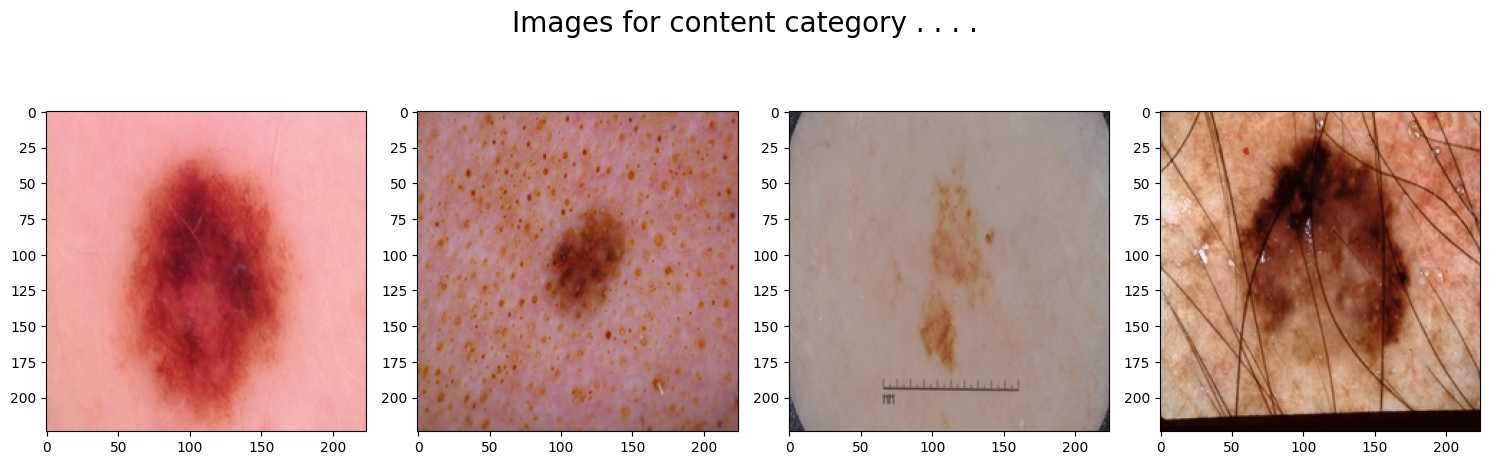

In [ ]:

for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [ ]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape


((2810,), (497,))

In [ ]:
# Split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(df['filepath'], df['label_bin'], test_size=0.15, random_state=10)

In [ ]:
def preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [307, 3000])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [ ]:
# image preprocessing function
def preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [ ]:
# Create TensorFlow datasets
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    .map(preprocess_image)
    .shuffle(buffer_size=len(X_train))
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    .map(preprocess_image)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
# Define the model
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

258076736/258076736 [==============================] - 9s 0us/step


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/2
88/88 [==============================] - 3616s 26s/step - loss: 0.4172 - accuracy: 0.8890 - auc: 0.0000e+00 - val_loss: 0.2055 - val_accuracy: 1.0000 - val_auc: 0.0000e+00
Epoch 2/2
88/88 [==============================] - 2304s 26s/step - loss: 0.0520 - accuracy: 1.0000 - auc: 0.0000e+00 - val_loss: 0.0322 - val_accuracy: 1.0000 - val_auc: 0.0000e+00


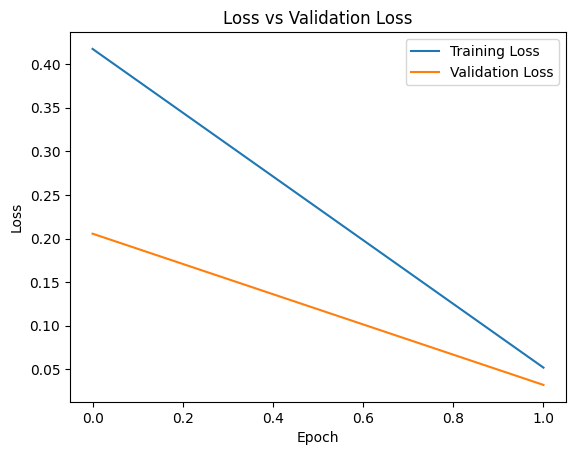

In [ ]:
# Plot the training and validation loss
hist_df = pd.DataFrame(history.history)
hist_df[['loss', 'val_loss']].plot()
plt.title('Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

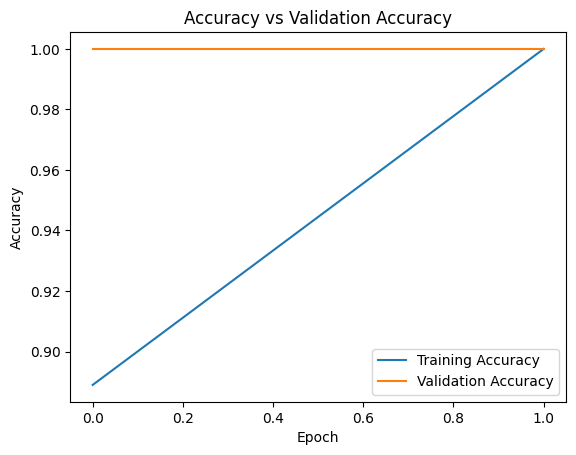

In [ ]:
# Plot the training and validation accuracy
hist_df[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()